In [2]:
#Alumnos:
#Belovsevich Mugerli, Victor Marcelo 97757
#Pereira, Martin 
#Petrucci, Maximiliano 95872
#link a repositorio de github: 

In [3]:
import datetime as datetime
import pandas as pd
import numpy as np
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt

#Permite ver los graficos sin colocar plt.show
%matplotlib inline 

In [4]:
propiedades = pd.read_csv("properati-AR-2017-08-01-properties-sell.csv", low_memory = False)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187482 entries, 0 to 187481
Data columns (total 27 columns):
id                            187482 non-null object
created_on                    187482 non-null object
operation                     187482 non-null object
property_type                 187482 non-null object
place_name                    187447 non-null object
place_with_parent_names       187482 non-null object
country_name                  187482 non-null object
state_name                    187482 non-null object
geonames_id                   158318 non-null float64
lat-lon                       118761 non-null object
lat                           118761 non-null float64
lon                           118761 non-null float64
price                         154443 non-null float64
currency                      154441 non-null object
price_aprox_local_currency    154443 non-null float64
price_aprox_usd               154443 non-null float64
surface_total_in_m2           12502

# FILTRADO DE DATOS

In [5]:
#Convierto la fecha de crecion en un datetime64[ns]
propiedades['created_on'] = pd.to_datetime(propiedades['created_on'])

#Se procede a filtrar las propiedades anteriores al 2014
propiedades = propiedades[propiedades.created_on.dt.year > 2013]

In [6]:
#Obtengo los datos de Capital Federal y de GBA
propiedadesCapGBA = propiedades.loc[(propiedades.state_name.str.contains('Capital Federal') | propiedades.state_name.str.contains('G.B.A') ) & propiedades.operation.str.contains('sell') , ['created_on','operation', 'property_type', 'state_name', 'place_name', 'lat', 'lon', 'price', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'description']]
propiedadesCapGBA = propiedadesCapGBA.loc[propiedadesCapGBA['place_name'] != 'Capital Federal', :]

In [7]:
#Filtro los datos cuyo precio por mt2 sea menor que 10000 y mayor a 100
propiedadesMenor10K = propiedadesCapGBA.loc[propiedadesCapGBA['price_usd_per_m2'] > 100, :].loc[propiedadesCapGBA['price_usd_per_m2'] < 10000,:]

In [8]:
#Filtro los registros que no tienen latitud ni longitud.
propiedadesMenor10K = propiedadesMenor10K.loc[propiedadesMenor10K['lat'].notnull() & propiedadesMenor10K['lat'].notnull(), :]

In [9]:
#Quiero ver la media y la mediana del mt2 en usd por barrio como tmb la cantidad de propiedades en cada barrio.
groupbyPlace = propiedadesMenor10K[['place_name', 'price_usd_per_m2']].groupby('place_name', as_index = False)['price_usd_per_m2']\
.agg({'media_por_barrio': np.mean, 'mediana_por_barrio': np.median, 'cant_prop': np.size})
groupbyPlace = groupbyPlace.loc[groupbyPlace['cant_prop'] > 4, :]

propiedadesPorBarrio = pd.merge(propiedadesMenor10K, groupbyPlace, on = 'place_name')

In [10]:
propiedadesPorBarrio = propiedadesPorBarrio.loc[propiedadesPorBarrio.surface_total_in_m2 <= 1000, :]

In [11]:
propiedadesPorBarrio['surface_total_in_m2'].describe()

count    46017.000000
mean       151.593781
std        162.753295
min         10.000000
25%         50.000000
50%         84.000000
75%        196.000000
max       1000.000000
Name: surface_total_in_m2, dtype: float64




## Analisis de  la relacion entre el precio por m2 y la superficie total de la propiedad

In [12]:
groupbySurface = propiedadesPorBarrio.groupby(pd.cut(propiedadesPorBarrio['surface_total_in_m2'], range(0, 1001, 100)), as_index= False)
groupbySurface['price_usd_per_m2'].agg(['mean','median' ,'size'])

#Se puede ver claramente que el precio por m2 no esta relacionado con la cantidad de mt2 que tenga la propiedad.

,mean,median,size
surface_total_in_m2,,,
"(0, 100]",2295.132021,2166.666667,26097
"(100, 200]",2111.263947,1788.804356,9166
"(200, 300]",1630.663168,1260.686883,5016
"(300, 400]",1382.642545,1014.605544,2478
"(400, 500]",1354.791417,940.000000,1222
"(500, 600]",1089.809137,687.964841,634
"(600, 700]",1003.368900,625.000000,413
"(700, 800]",680.776104,415.584416,406
"(800, 900]",595.955327,415.700307,332


In [13]:
#Determino si el precio por mt2 esta determinado por los mt2 de la propiedad.
#Para eso veo la relacion Departamentos vs Casas



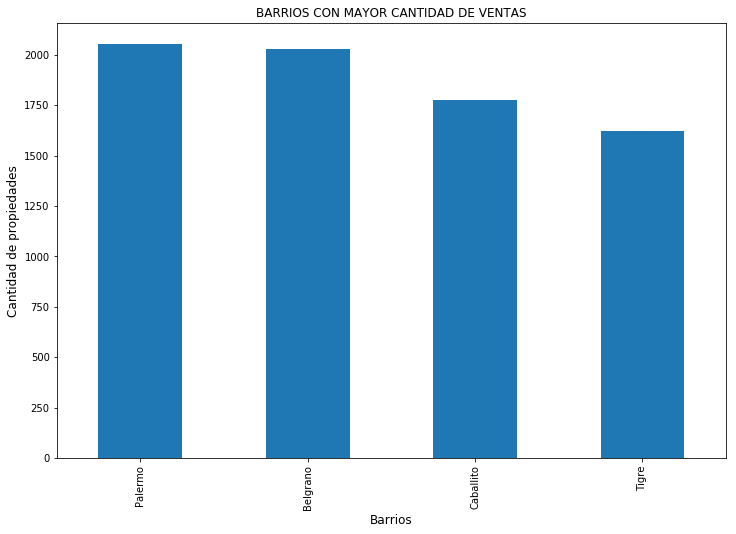

In [14]:
#Vemos los barrios que tienen mayor cantidad de ventas y lo utilizo para saber que tipo de propiedad se vendio mas
ventasPorBarrio = propiedadesPorBarrio.groupby('place_name')
ventasPorBarrioTop5 = ventasPorBarrio['created_on'].count().sort_values(ascending = False).head(4)
ventasPorBarrioTop5.plot(kind = 'bar', figsize= (12, 8))

plt.ylabel('Cantidad de propiedades', fontsize = 12);
plt.xlabel('Barrios', fontsize = 12);
plt.title('BARRIOS CON MAYOR CANTIDAD DE VENTAS')

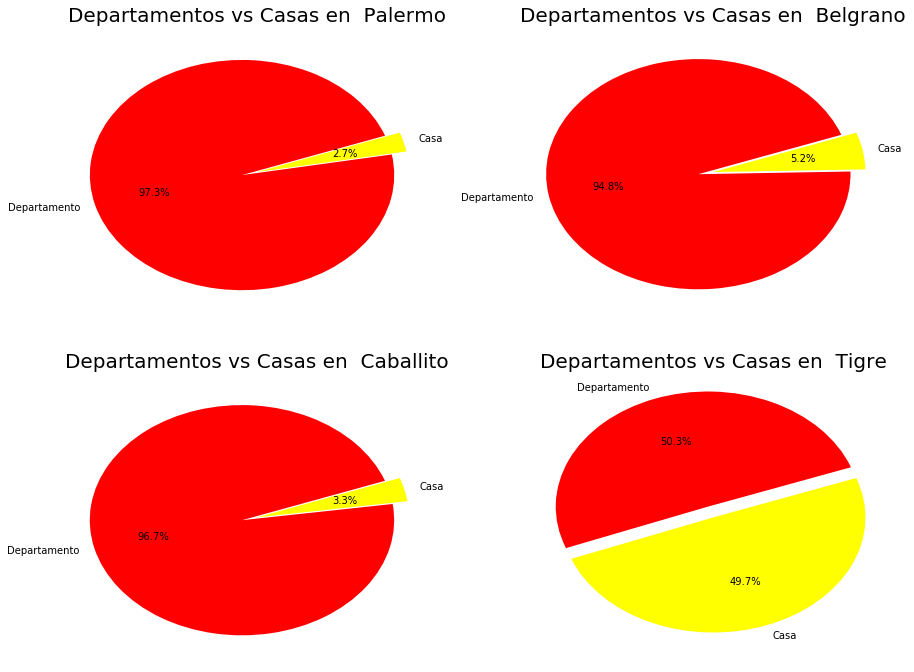

In [15]:
#Vemos que tipo de propiedad se vendio mas en los barrios con mayores ventas
dataTipoProp = [ventasPorBarrio.get_group('Palermo'), ventasPorBarrio.get_group('Belgrano'), ventasPorBarrio.get_group('Caballito'), ventasPorBarrio.get_group('Tigre')]
dataNombres = ['Palermo', 'Belgrano', 'Caballito', 'Tigre']
nombres = ['Departamento', 'Casa']

plt.figure(figsize=(15, 18));

for i in range(len(dataTipoProp)):
    tam = []
    tam.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'apartment', :]['created_on'].count())
    tam.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'house', :]['created_on'].count()) 
    
    ax = plt.subplot(321 + i );
    plt.pie(tam, labels = nombres, autopct='%1.1f%%', startangle = 20, colors=['red', 'yellow'], explode=(0.1, 0))
    plt.title('Departamentos vs Casas en  ' + dataNombres[i], fontsize = 20);
   

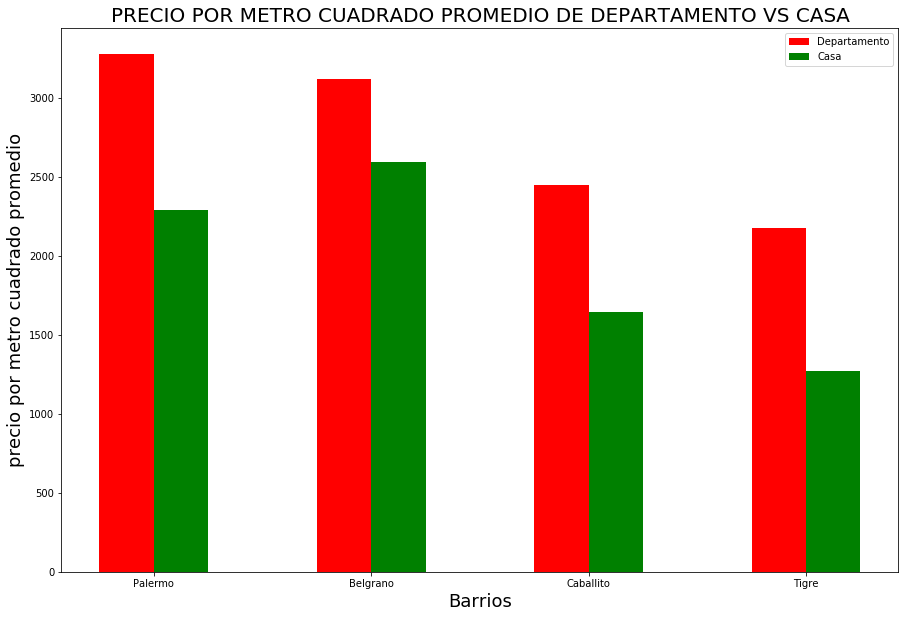

In [16]:
#Vemos que propiedad posee en promedio un mayor precio por m2 
deptosMean = []
casasMean = []

plt.figure(figsize=(15, 10));

for i in range(len(dataTipoProp)):
    deptosMean.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'apartment', :]['price_usd_per_m2'].mean())
    casasMean.append(dataTipoProp[i].loc[dataTipoProp[i]['property_type'] == 'house', :]['price_usd_per_m2'].mean())

x = np.arange(4)
plt.bar(x, deptosMean, color = 'red', width=0.25 );
plt.bar(x + 0.25, casasMean, color ='green',  width=0.25 );
plt.xticks(x + 0.125, dataNombres, size = 'medium')
plt.title('PRECIO POR METRO CUADRADO PROMEDIO DE DEPARTAMENTO VS CASA', fontsize = 20)
plt.xlabel('Barrios', fontsize = 18)
plt.ylabel('precio por metro cuadrado promedio', fontsize = 18)
plt.legend(nombres)


### Se puede ver claramente que en los barrios con mayores ventas, la propiedad que predomina son los departamentos y en dichos barrios el precio por m2 de los mismos es superior al de las otras propiedades

In [17]:
dataSoloCasasyDeptos = propiedadesPorBarrio.loc[(propiedadesPorBarrio['property_type'] == 'house') | (propiedadesPorBarrio['property_type'] == 'apartment'), :]
dataSoloCasasyDeptosBarrios = dataSoloCasasyDeptos.loc[dataSoloCasasyDeptos['place_name'].notnull(),:]
listaBarrios = dataSoloCasasyDeptosBarrios.loc[:,'place_name'].drop_duplicates().tolist()

In [18]:
from heapq import heappush, nlargest

ventasPorBarrio = dataSoloCasasyDeptos.groupby('place_name')
barriosMayorCasasQueDeptos = []
nombres = ['Departamento', 'Casa']

for i in range(len(listaBarrios)):
    tam = []
    barrio = ventasPorBarrio.get_group(listaBarrios[i])
    tam.append(barrio.loc[barrio['property_type'] == 'apartment', :]['created_on'].count())
    tam.append(barrio.loc[barrio['property_type'] == 'house', :]['created_on'].count())
    diff = tam[1] - tam[0] #diferencia entre la cantidad casas y departamentos
    if (diff > 10):
        barriosMayorCasasQueDeptos.append((listaBarrios[i], tam, barrio, diff))

#Se eligen los 5 barrios con mayor diferencia entre la cantidad de casas y deptos
dataCasasMayorDeptos = list(map(lambda x: (x[0], x[1], x[2]), nlargest(4, barriosMayorCasasQueDeptos, key = lambda x: x[3]))) 

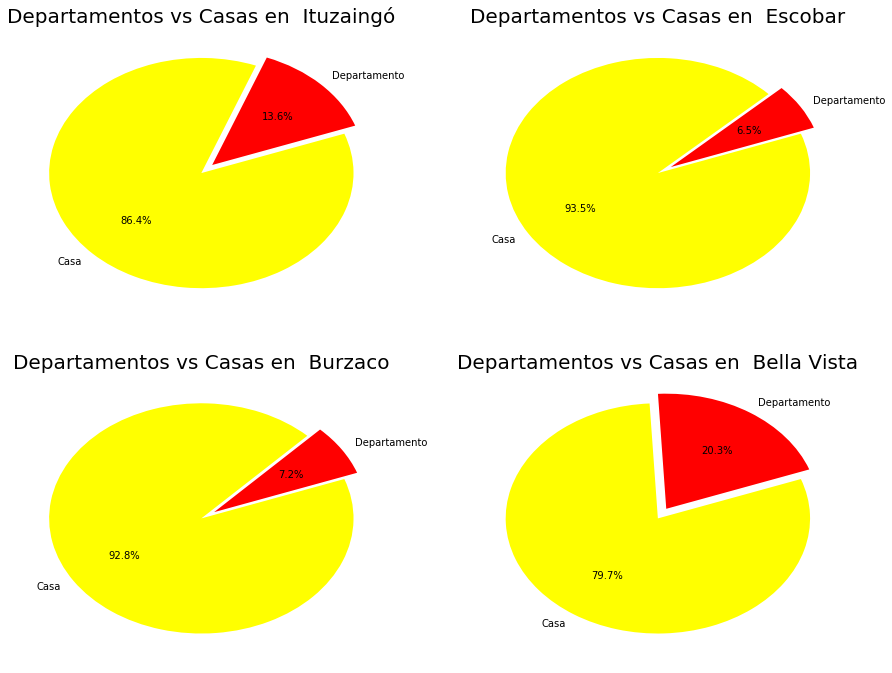

In [19]:
deptosMean = []
casasMean = []
dataNombres = []

plt.figure(figsize=(15, 18));

for i in range(len(dataCasasMayorDeptos)):
    barrio = dataCasasMayorDeptos[i][2]
    deptosMean.append(barrio.loc[barrio['property_type'] == 'apartment', :]['price_usd_per_m2'].mean())
    casasMean.append(barrio.loc[barrio['property_type'] == 'house', :]['price_usd_per_m2'].mean())
    dataNombres.append(dataCasasMayorDeptos[i][0])
    
    ax = plt.subplot(321 + i );
    plt.pie(dataCasasMayorDeptos[i][1], labels = nombres, autopct='%1.1f%%', startangle = 20, colors=['red', 'yellow'], explode=(0.1, 0))
    plt.title('Departamentos vs Casas en  ' + dataCasasMayorDeptos[i][0], fontsize = 20);


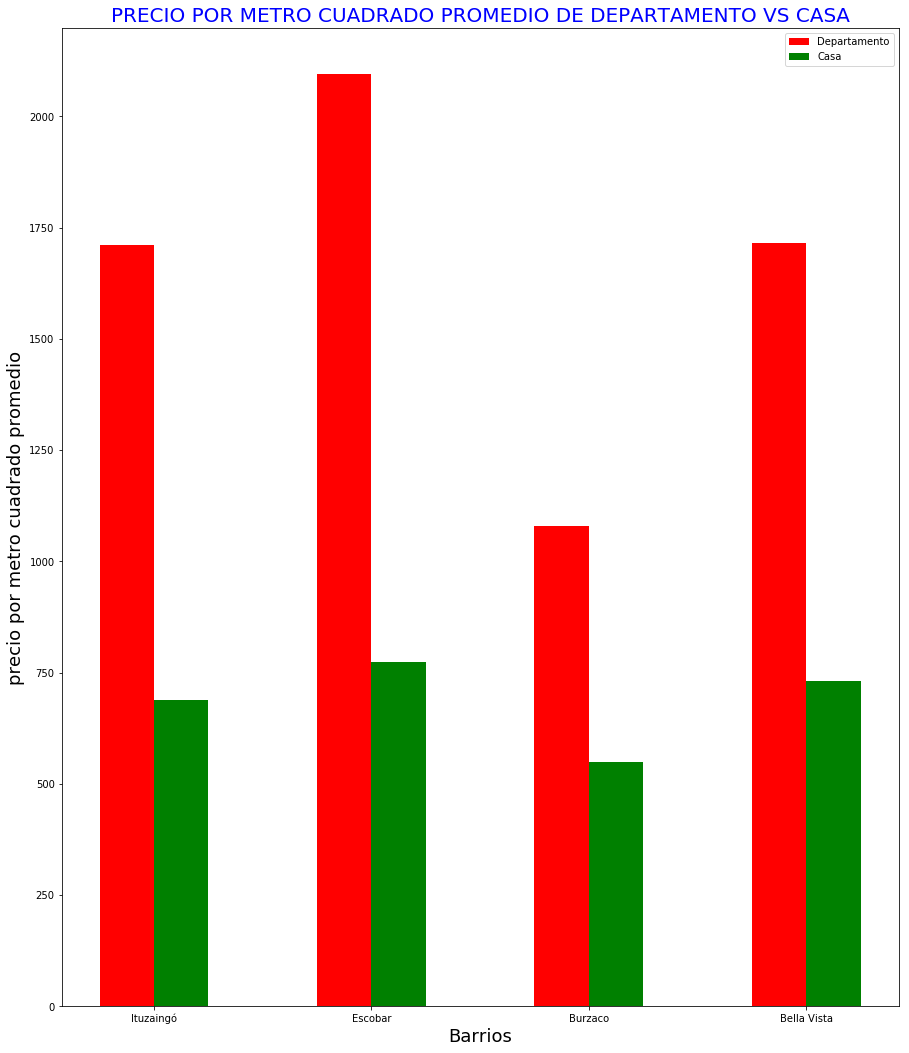

In [20]:
plt.figure(figsize=(15, 18));
x = np.arange(4)
plt.bar(x, deptosMean, color = 'red', width=0.25 );
plt.bar(x + 0.25, casasMean, color ='green',  width=0.25 );
plt.xticks(x + 0.125, dataNombres, size = 'medium')
plt.title('PRECIO POR METRO CUADRADO PROMEDIO DE DEPARTAMENTO VS CASA', fontsize = 20, color = 'blue')
plt.xlabel('Barrios', fontsize = 18)
plt.ylabel('precio por metro cuadrado promedio', fontsize = 18)
plt.legend(nombres)

### Conclusion: el precio por m2 de los departamentos es mayor al de las casas y esto no solo pasa en los barrios en el que predominan los departamentos sino tambien en aquellos barrios en los cuales hay mayor cantidad de casas. Esto se debe a que hay una mayor demanda de departamentos que de cualquier otro tipo de propiedad y esto es justamente lo que aumenta su precio con respecto a las demas.

### Analizo el crecimiento en las ventas de departamentos de los ultimos 2 anios.

In [21]:
deptos2017 = propiedadesPorBarrio.loc[(propiedadesPorBarrio.created_on.dt.year == 2017) & (propiedadesPorBarrio.property_type == 'apartment'), :]
deptos2017['created_on'].count()

20766

In [22]:
deptos2016 = propiedadesPorBarrio.loc[(propiedadesPorBarrio.created_on.dt.year == 2016) & (propiedadesPorBarrio.property_type == 'apartment'), :]
deptos2016['created_on'].count()

6690

In [23]:
deptos2015 = propiedadesPorBarrio.loc[(propiedadesPorBarrio.created_on.dt.year == 2015) & (propiedadesPorBarrio.property_type == 'apartment'), :]
deptos2015['created_on'].count()

1451

# VENTAS EN LOS BARRIOS 

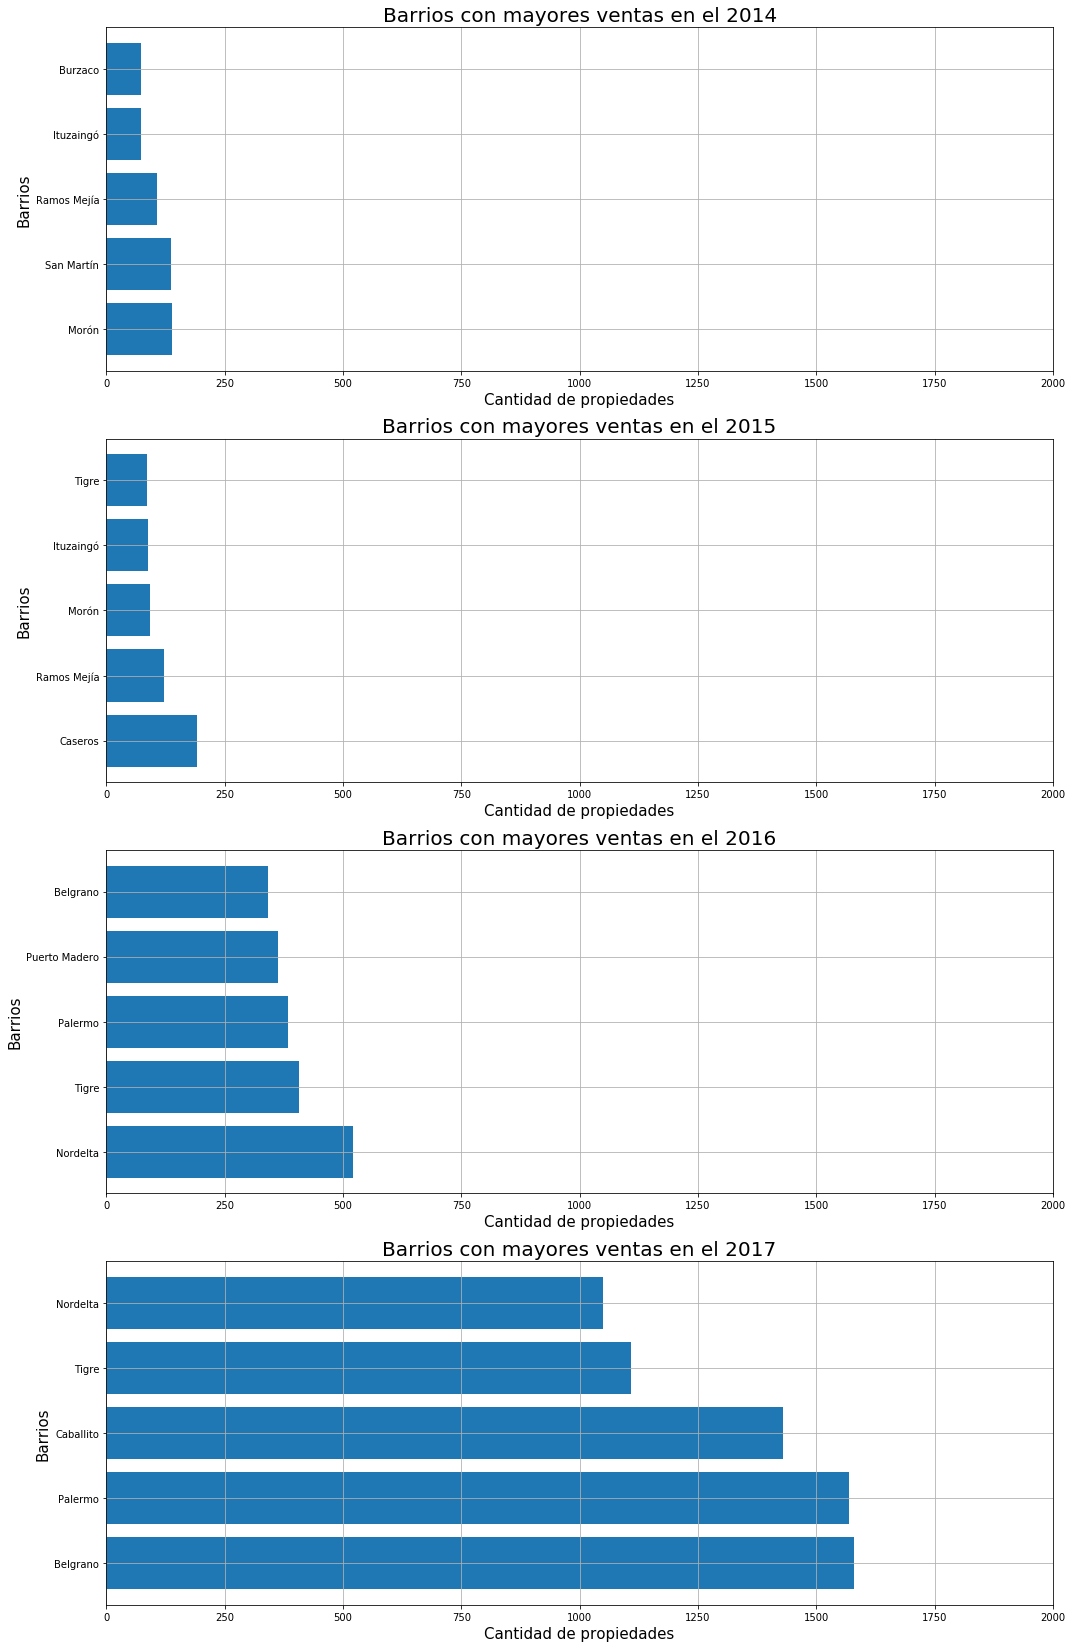

In [24]:
#Veo cuales son los barrios que obtuvieron la mayor cantidad de ventas en los ultimos 4 anios

barrios2017 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2017]
barrios2016 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2016]
barrios2015 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2015]
barrios2014 = propiedadesPorBarrio[propiedadesPorBarrio.created_on.dt.year == 2014]

barrios = [barrios2014, barrios2015, barrios2016, barrios2017]
barrios_anios = ['2014', '2015', '2016', '2017']

plt.figure(figsize=(15, 23));

for i in range(len(barrios)):
    barrios[i] = barrios[i].groupby('place_name')['cant_prop'].count().sort_values(ascending=False)
    
    ax = plt.subplot(411 + i );
    ax.set_xlim([0, 2000]);

    plt.grid(True);
    plt.title('Barrios con mayores ventas en el ' + barrios_anios[i], fontsize = 20);
    plt.xlabel('Cantidad de propiedades', fontsize = 15);
    plt.ylabel('Barrios', fontsize = 15);
    ax.barh([j for j in range(5)], [valor for valor in barrios[i][:5].values], 
            tick_label=[viaje for viaje in barrios[i][:5].index.values]);
plt.tight_layout();


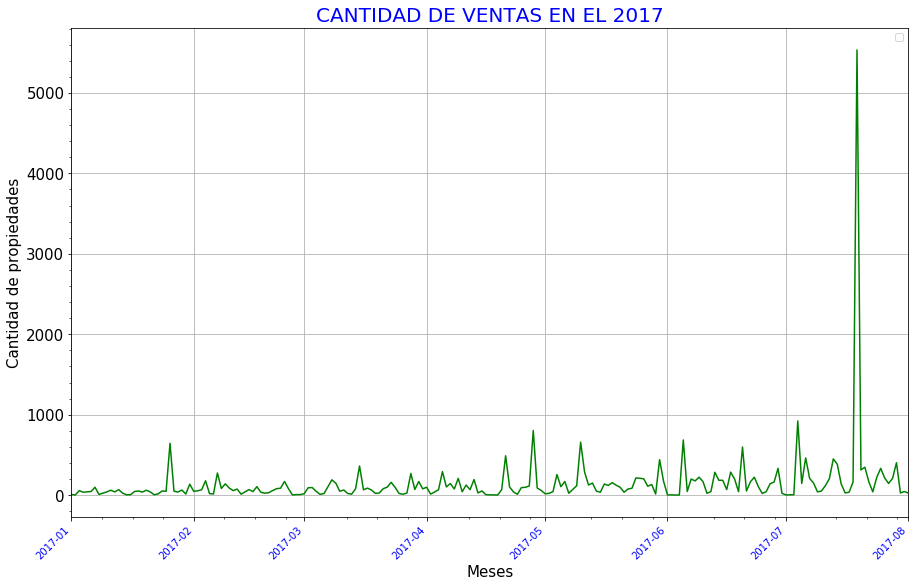

In [25]:
#Ventas realizadas durante el transcurso del 2017
dias2017 = barrios2017.groupby('created_on')['cant_prop'].count()

dias2017.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL 2017', fontsize = 20, color = 'blue')  
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

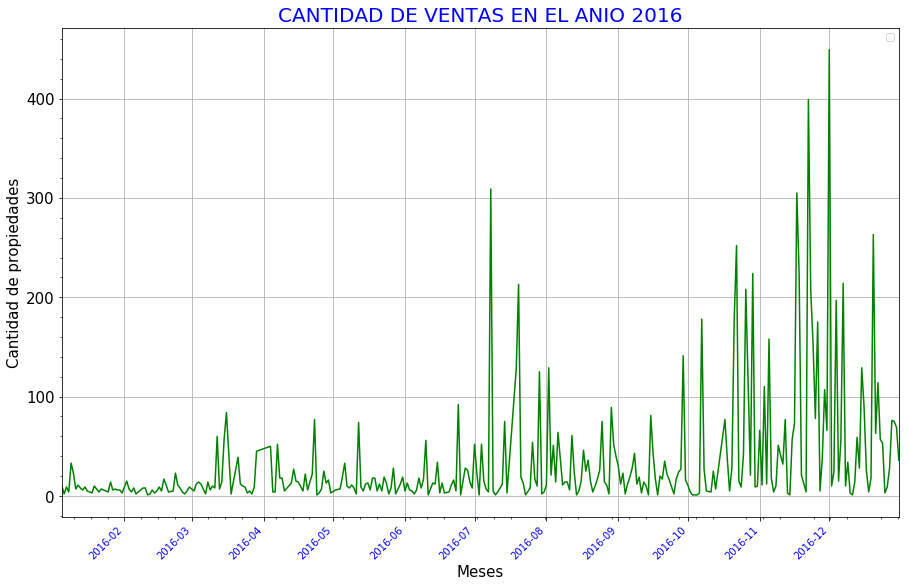

In [28]:
#Ventas realizadas durante el transcurso del 2016

dias2016 = barrios2016.groupby('created_on')['cant_prop'].count()

dias2016.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL ANIO 2016', fontsize = 20, color = 'blue')
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

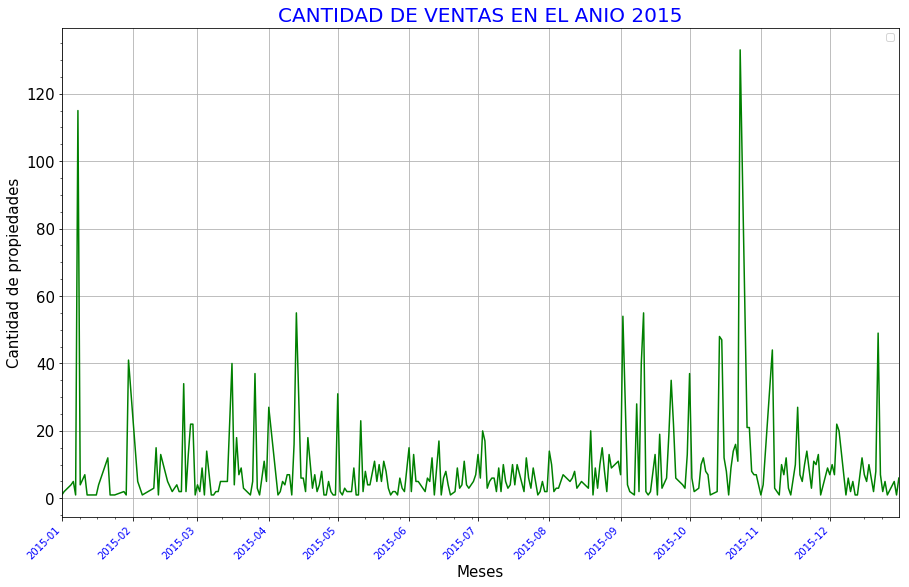

In [29]:
#Ventas realizadas durante el transcurso del 2015
dias2015 = barrios2015.groupby('created_on')['cant_prop'].count()

dias2015.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL ANIO 2015', fontsize = 20, color = 'blue')  # Colocamos el título del gráfico
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

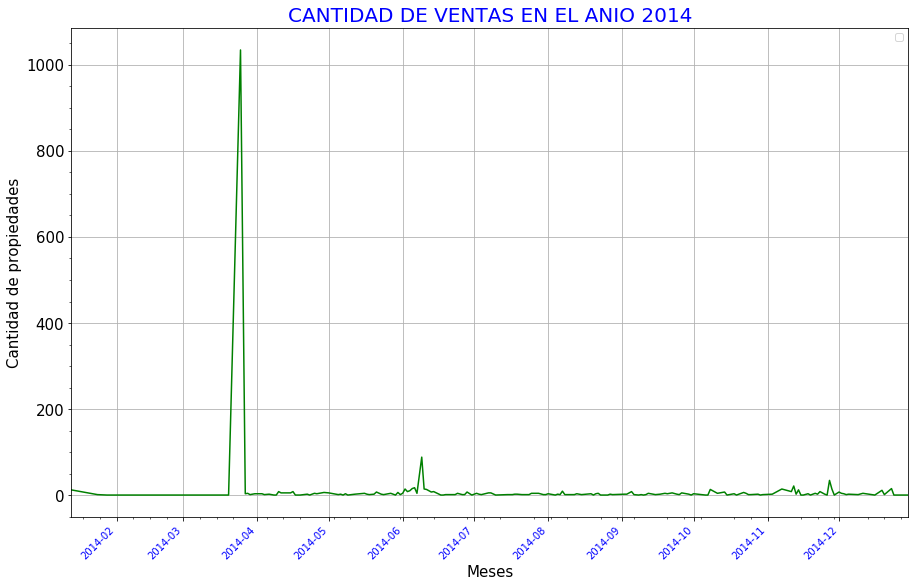

In [30]:
#Ventas realizadas durante el transcurso del 2014
dias2014 = barrios2014.groupby('created_on')['cant_prop'].count()

dias2014.plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.xticks(size = 'medium', color = 'b',rotation = 45); 
plt.grid(True);
plt.minorticks_on();
plt.title(u'CANTIDAD DE VENTAS EN EL ANIO 2014', fontsize = 20, color = 'blue')  
plt.ylabel('Cantidad de propiedades', fontsize = 15);
plt.xlabel('Meses', fontsize = 15);
plt.legend('');

# Relacion entre la localizacion de la propiedad y su precio por m2

In [31]:
#Funcion para calcular distancias entre coordenadas (lat, lon)
from math import sin,cos,sqrt,asin,pi

#Formula del Harvesine sacada de
#https://joseguerreroa.wordpress.com/2012/11/13/distancia-entre-dos-puntos-de-la-superficie-terrestre-mediante-la-formula-de-haversine-con-python/
#coord = (lat, long)
def distancia(coord1, coord2):
    rTierra = 6374000 #metros
    c = pi/180 #para pasar a raddianes
    d = 2*rTierra*asin(sqrt(sin(c*(coord2[0]-coord1[0])/2)**2 + cos(c*coord1[0])*cos(c*coord2[0])*sin(c*(coord2[1]-coord1[1])/2)**2))
    return d

def obtener_geoPos(reg):
    lat, lon = reg
    return lat,lon

In [32]:
#Obtengo la latitud y longitud en una tupla.
propiedadesDistancia = propiedadesPorBarrio.copy(deep=True)
propiedadesDistancia['geoPos'] = propiedadesDistancia.loc[:,['lat', 'lon']].apply(obtener_geoPos, axis = 1)

### Analisis relacionado a la distancia al centro de la ciudad

In [33]:
def obtener_distancia_al_centro(geoPos):
    centro = (-34.608056,  -58.370278)# Se utilizo las coordenadas de la Casa Rosada
    return distancia(geoPos, centro)

In [34]:
propiedadesDistanciaCentro = propiedadesDistancia.copy(deep = True)
propiedadesDistanciaCentro.loc[:,'distancia_al_centro'] = propiedadesDistanciaCentro.loc[:, 'geoPos'].apply(obtener_distancia_al_centro)
propiedadesDistanciaCentro = propiedadesDistanciaCentro.loc[propiedadesDistanciaCentro.distancia_al_centro < 64000, :]

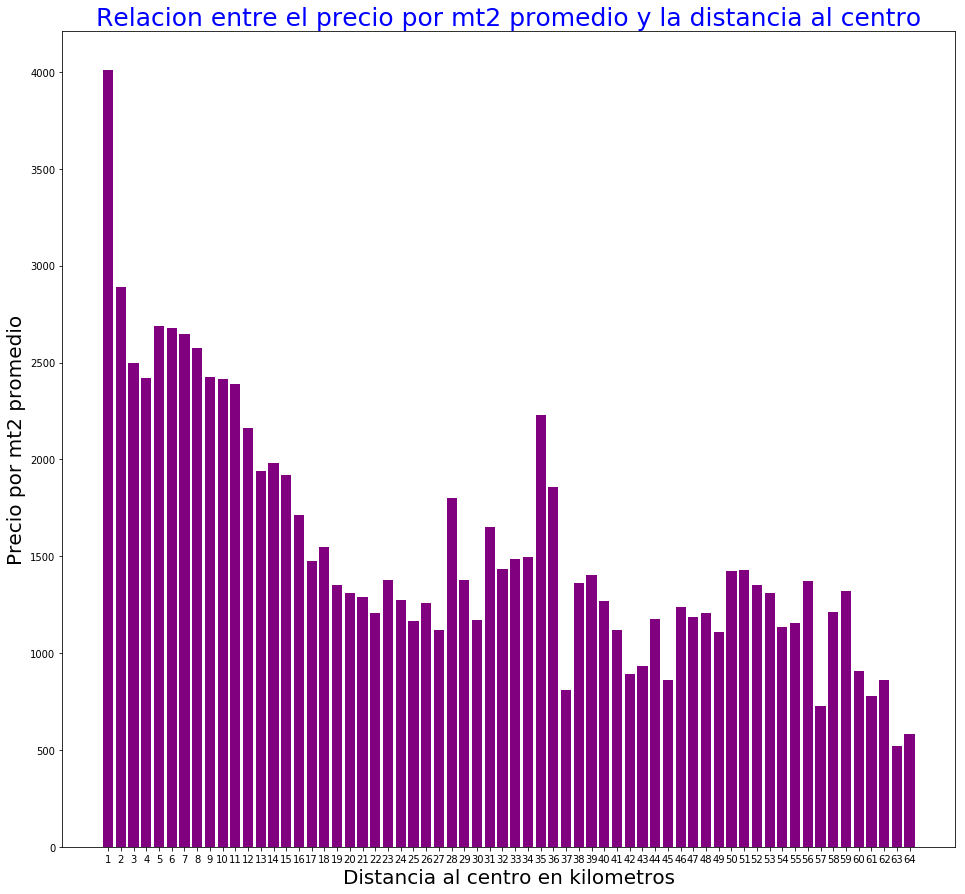

In [35]:
groupbyDistanciaCentro = propiedadesDistanciaCentro.groupby(pd.cut(propiedadesDistanciaCentro['distancia_al_centro'], range(0, 65000, 1000)), as_index= False)
mediaPorDistanciaCentro = groupbyDistanciaCentro['price_usd_per_m2'].agg(['mean'])
distKm = np.arange(groupbyDistanciaCentro.ngroups) + 1
plt.figure(figsize=(16, 15));
plt.bar(distKm, mediaPorDistanciaCentro['mean'], width= 0.8, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia al centro', fontsize = 25, color = 'Blue')
plt.xlabel('Distancia al centro en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)

#### Por lo general, el grafico demuestra una relacion inversamente proporcional entre la distancia al centro y el precio por m2 de la propiedad. Se puede ver tambien que hay una zona (desde 28 hasta 35 km) en la cual dicha relacion no se cumple , a continuacion se analizara dicho problema.

In [36]:
#Analizo la zona, en la cual el grafico anterior presenta problemas.(28 a 35 km)
zonaProblematica = propiedadesDistanciaCentro.loc[(propiedadesDistanciaCentro.distancia_al_centro < 35000) & (propiedadesDistanciaCentro.distancia_al_centro > 28000), :]\
.groupby('place_name')['price_usd_per_m2'].agg(['mean', 'size'])
zonaProblematica.sort_values('size', ascending = False).head()


,mean,size
place_name,,
Nordelta,2440.062640,1317
San Miguel,1260.380025,723
Tigre,1561.687502,515
Ituzaingó,681.406128,396
Muñiz,1299.996365,204


### La mayoria de las casas en dicha zona son de Nordelta, el cual es uno de los barrios mas caros, y el cual claramente no se ve afectado por la distancia al centro de la ciudad.

##### Su precio depende de otro factor. Acceso al Rio? Cercania al delta del Rio?


In [37]:
#calcula la distancia en metros entre la propiedad y la villa Fuerte Apache. Recibe por parametro un registro
def distanciaAFuerteApache(geoPos):
      #Ubicacion
    fuerteApache = (-34.622374, -58.539921) #Tomamos este como el punto central de la villa
    return distancia(geoPos, fuerteApache)

def distanciaACarlosGardel(geoPos):
    #Ubicacion
    carlosGardel = (-34.6244, -58.5778) #Tomamos este como el punto central de la villa
    return distancia(geoPos, carlosGardel)

#Informacion sacada de 
#http://blogs.monografias.com/estampas-de-buenos-aires/2015/05/21/las-villas-de-emergencia-en-la-ciudad/
def distanciaAVillas(geoPos):
    
    Indoamericano = (-34.665202, -58.468526)# Se tomaron estas coordenadas ya que alrededor hay una gran cantidad de villas
    return distancia(geoPos, Indoamericano)

In [38]:
propiedadesCercanasAIndoamericano = propiedadesDistancia.copy(deep = True)
propiedadesCercanasAIndoamericano.loc[:, 'distanciaAIndoamericano'] = propiedadesCercanasAIndoamericano['geoPos'].apply(distanciaAVillas)

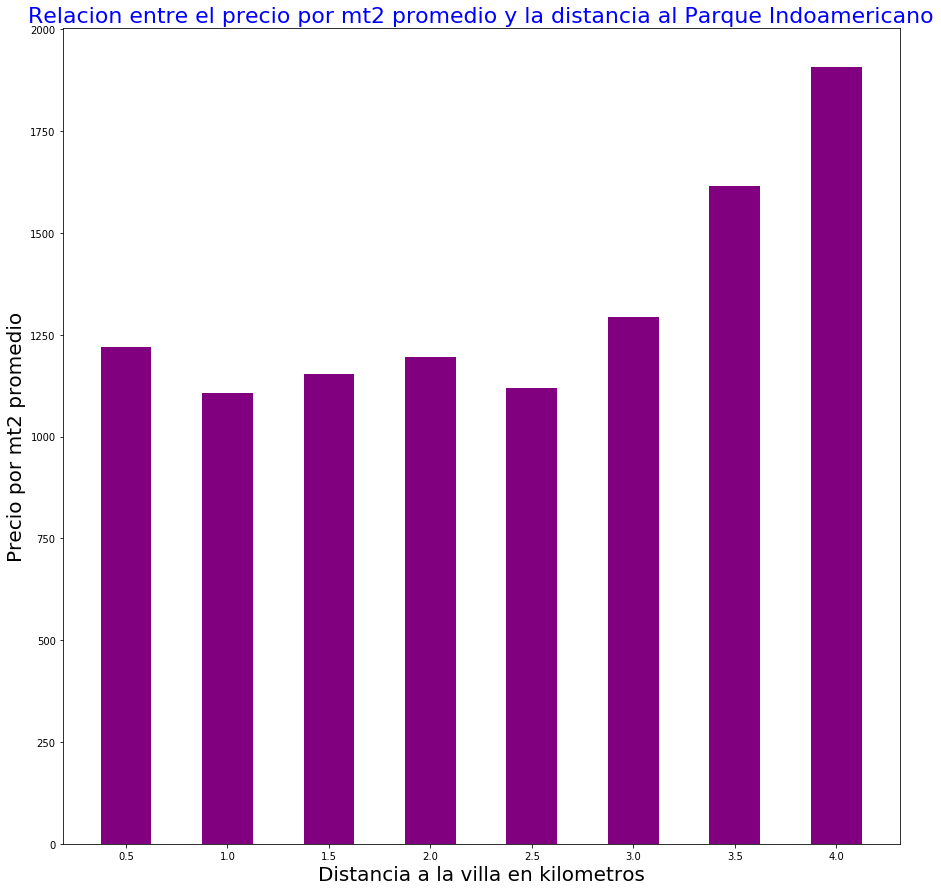

In [39]:
#vamos a comparar propiedades que estan entre a 4000mts de distancia.
propiedadesCercanasAIndoamericano = propiedadesCercanasAIndoamericano.loc[propiedadesCercanasAIndoamericano['distanciaAIndoamericano'] < 4000, :]
groupbyDistVillas = propiedadesCercanasAIndoamericano.groupby(pd.cut(propiedadesCercanasAIndoamericano['distanciaAIndoamericano'], range(0, 4001, 500)), as_index= False)
mediaPrecioVilla = groupbyDistVillas['price_usd_per_m2'].agg(['mean'])
distKm = (np.arange(groupbyDistVillas.ngroups) + 1)*0.5

plt.figure(figsize=(15, 15));
plt.bar(distKm, mediaPrecioVilla['mean'], width= 0.25, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia al Parque Indoamericano', fontsize = 22, color = 'Blue')
plt.xlabel('Distancia a la villa en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)

#No se ve un tendencia clara cuando se analiza las propiedades mas cercanas. 
#Apartir de los 3,5km se logra ver un aumento en el precio por m2, 
#pero no es seguro determinar que el mismo se deba a la distancia a la concentracion de villas. 
#Otros factores podrian estar influenciando ese cambio.

In [40]:
propiedadesCercanasAFuerteApache = propiedadesDistancia.copy(deep = True)
propiedadesCercanasAFuerteApache.loc[:, 'distanciaAFuerteApache'] = propiedadesCercanasAFuerteApache['geoPos'].apply(distanciaAFuerteApache)

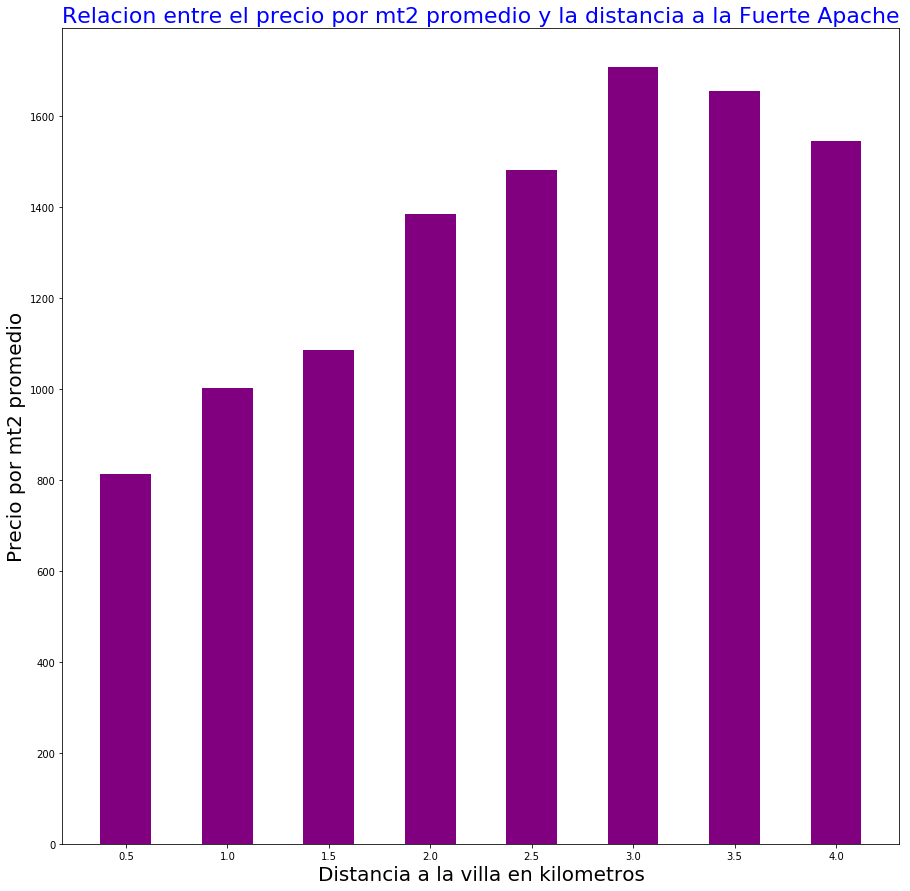

In [41]:
#vamos a comparar propiedades que estan entre a 4000mts de distancia.
propiedadesCercanasAFuerteApache = propiedadesCercanasAFuerteApache.loc[propiedadesCercanasAFuerteApache['distanciaAFuerteApache'] < 4000, :]
groupbyDistFuerteApache = propiedadesCercanasAFuerteApache.groupby(pd.cut(propiedadesCercanasAFuerteApache['distanciaAFuerteApache'], range(0, 4001, 500)), as_index= False)
mediaPrecioFuerteApache = groupbyDistFuerteApache['price_usd_per_m2'].agg(['mean'])
distKm = (np.arange(groupbyDistFuerteApache.ngroups) + 1)*0.5

plt.figure(figsize=(15, 15));
plt.bar(distKm, mediaPrecioFuerteApache['mean'], width= 0.25, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia a la Fuerte Apache', fontsize = 22, color = 'Blue')
plt.xlabel('Distancia a la villa en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)
#En las cercanias de la villa Fuerte Apache se logra ver un notable descenso del precio por m2 de las propiedades.
#Tambien se percibe que el aumento en el precio es considerable mientras se acrecienta la distancia 
#con respecto a la villa.

In [42]:
propiedadesCercanasACarlosGardel = propiedadesDistancia.copy(deep = True)
propiedadesCercanasACarlosGardel.loc[:, 'distanciaACarlosGardel'] = propiedadesCercanasACarlosGardel['geoPos'].apply(distanciaACarlosGardel)

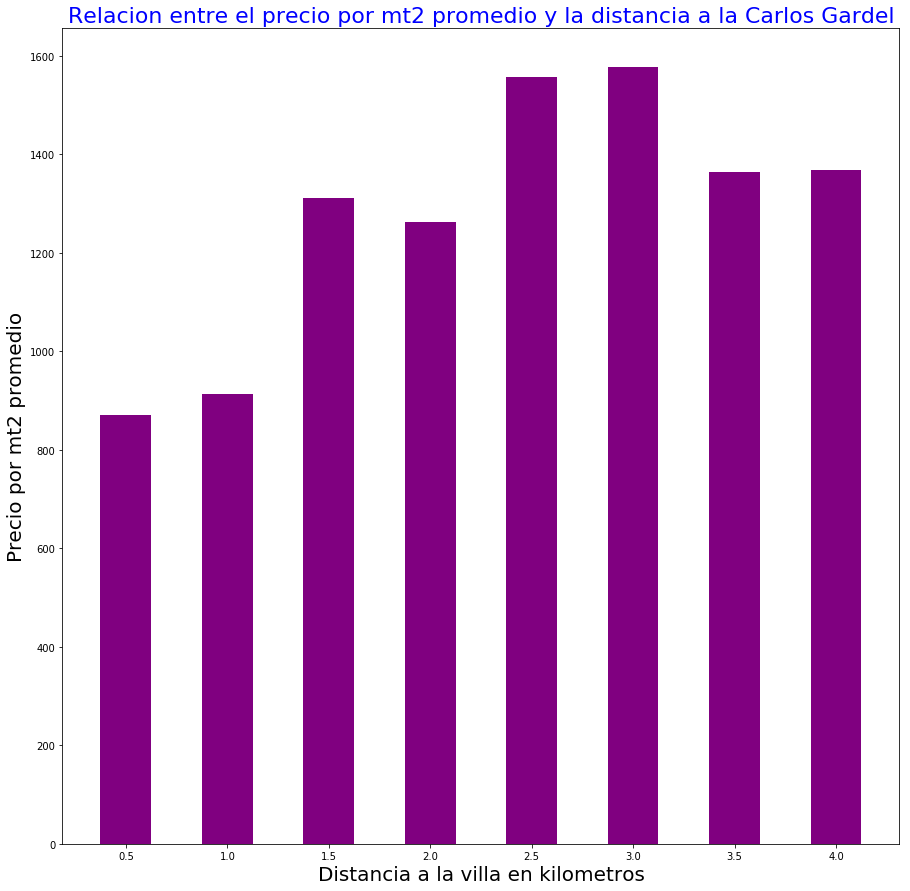

In [43]:
#vamos a comparar propiedades que estan entre a 4000mts de distancia.
propiedadesCercanasACarlosGardel = propiedadesCercanasACarlosGardel.loc[propiedadesCercanasACarlosGardel['distanciaACarlosGardel'] < 4000, :]
groupbyDistCarlosGardel = propiedadesCercanasACarlosGardel.groupby(pd.cut(propiedadesCercanasACarlosGardel['distanciaACarlosGardel'], range(0, 4001, 500)), as_index= False)
mediaPrecioCarlosGardel = groupbyDistCarlosGardel['price_usd_per_m2'].agg(['mean'])
distKm = (np.arange(groupbyDistCarlosGardel.ngroups) + 1)*0.5

plt.figure(figsize=(15, 15));
plt.bar(distKm, mediaPrecioCarlosGardel['mean'], width= 0.25, color = 'purple')
plt.xticks(distKm, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la distancia a la Carlos Gardel', fontsize = 22, color = 'Blue')
plt.xlabel('Distancia a la villa en kilometros', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)
#En las cercanias de la villa Carlos Gardel se logra ver un notable descenso del precio por m2 de las propiedades.
#Tambien se percibe que el aumento en el precio es considerable mientras se acrecienta la distancia 
#con respecto a la villa.

## Analisis de la relacion entre el precio por m2 y la cercania a estaciones de subtes.

In [44]:
def obtener_subtes_cercanos(geoPos):
    lineaE = [(-34.609563795, -58.374052048), (-34.612989872, -58.377828598),(-34.618217016, -58.381583691), (-34.622366711, -58.385403156),
              (-34.622455000, -58.391432762), (-34.623125994, -58.397119045), (-34.623867613, -58.402848244), (-34.624679854, -58.409628868),
              (-34.625545060, -58.416645527), (-34.626798708, -58.426151276), (-34.628069994, -58.434305191), (-34.631618899, -58.442544937),
              (-34.636385845, -58.450076580), (-34.639563657, -58.457865715), (-34.642829615, -58.461534977)]
    
    lineaA = [(-34.608557137, -58.374567032), (-34.609086958, -58.382549286), (-34.609404849, -58.386669159), (-34.609652097, -58.398342133),
              (-34.609687418, -58.406839371), (-34.610782364, -58.415164948), (-34.615091365, -58.429327011), (-34.611736015, -58.421730995),
              (-34.618022770, -58.435893059), (-34.620459643, -58.441429138), (-34.623567434, -58.448810577), (-34.626533854, -58.456192017)]
    
    lineaB = [(-34.602870174, -58.369545937), (-34.603294060, -58.374567032), (-34.604141827, -58.386712074), (-34.604530384, -58.392891884),
              (-34.604530384, -58.399200439), (-34.604565707, -58.405079842), (-34.604106503, -58.411602974), (-34.603152765, -58.421001434),
              (-34.602057719, -58.430914879), (-34.599055099, -58.439583778), (-34.591671724, -58.447651863), (-34.584111033, -58.466534615),
              (-34.581567095, -58.473873138), (-34.573828804, -58.487434387)]
    
    lineaC = [(-34.590505868, -58.376069069), (-34.595522465, -58.377442360), (-34.602022395, -58.378129005), (-34.608980994, -58.380703926),
              (-34.612407095, -58.380532265), (-34.618058088, -58.380274773), (-34.622331395, -58.379931450), (-34.627964055, -58.381175995)]
    
    lineaD = [(-34.607621111, -58.374266624), (-34.604336105, -58.380360603), (-34.601845773, -58.385360241), (-34.599426017, -58.392827511),
              (-34.599531993, -58.397955894), (-34.594497974, -58.402633667), (-34.591636395, -58.407139778), (-34.588244767, -58.411281109),
              (-34.585170985, -58.415830135), (-34.578440064, -58.426043987), (-34.575295247, -58.434326649), (-34.570242091, -58.444347382),
              (-34.566125132, -58.452243805), (-34.562396722, -58.456299305), (-34.555982053, -58.462092876)]
    
    lineaH = [(-34.588138777, -58.398170471), (-34.598684179, -58.403813839), (-34.603700283, -58.405380249), (-34.608945673, -58.405938148),
              (-34.615515189, -58.404779434), (-34.622896444, -58.402483463), (-34.629341261, -58.400981426), (-34.635255927, -58.399178982),
              (-34.637515748, -58.405981064), (-34.641796880, -58.412622213)]
    
    subtes = lineaA + lineaB + lineaC + lineaD + lineaE + lineaH
    cant_subtes_cercanos = 0
    
    for i in range(len(subtes)):
        if (distancia(geoPos, subtes[i]) <= 700):
            cant_subtes_cercanos += 1
    return cant_subtes_cercanos
    

In [45]:
propiedadesCercanasSubte = propiedadesDistancia.copy(deep = True)
propiedadesCercanasSubte.loc[:,'cant_subtes_cercanos'] = propiedadesCercanasSubte['geoPos'].apply(obtener_subtes_cercanos)

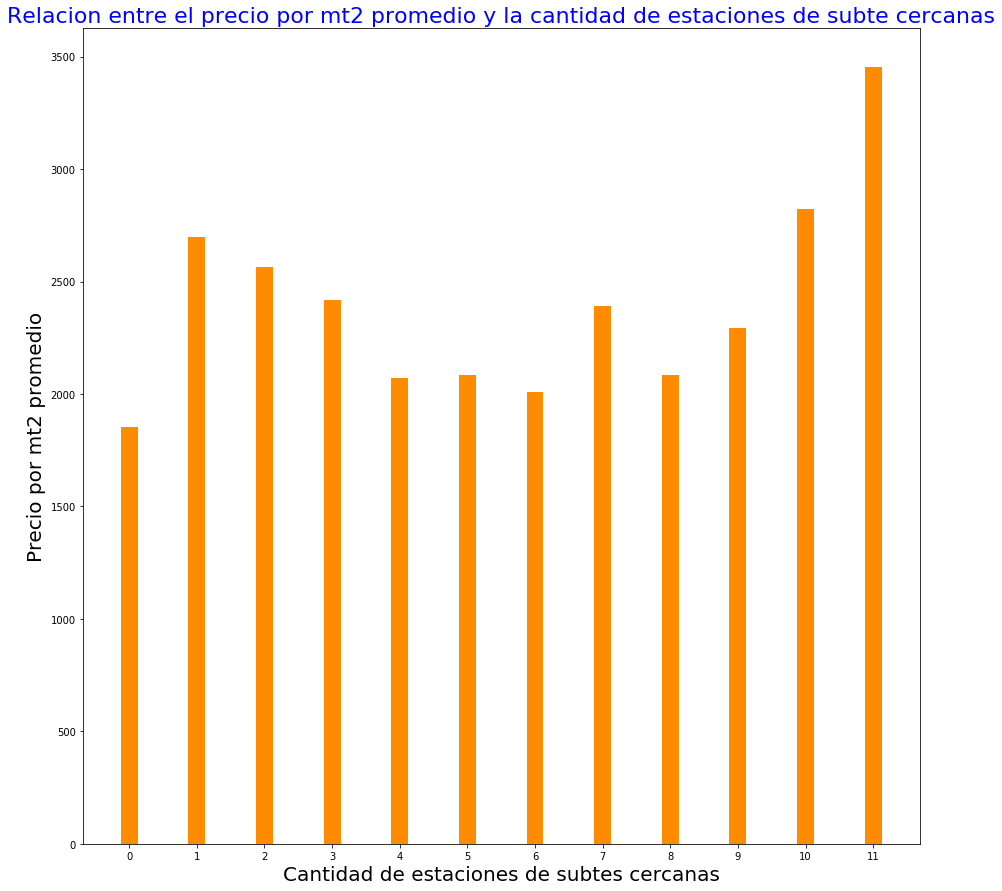

In [46]:
#Las propiedades que tienen al menos una estacion de subte a 700m tienen en promedio mayor precio por m2
groupbySubte = propiedadesCercanasSubte.groupby('cant_subtes_cercanos')
mediaGroupbySubte = groupbySubte['price_usd_per_m2'].agg(['mean'])

cant_estaciones = np.arange(groupbySubte.ngroups)

plt.figure(figsize=(15, 15));
plt.bar(cant_estaciones, mediaGroupbySubte['mean'], width= 0.25, color = 'darkorange')
plt.xticks(cant_estaciones, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la cantidad de estaciones de subte cercanas', fontsize = 22, color = 'Blue')
plt.xlabel('Cantidad de estaciones de subtes cercanas', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)
#Este grafico nos demuestra que las propiedades que tienen al menos una estacion de subte cerca, 
#tienen en promedio un precio por m2 mayor a aquellas que no poseen un estacion de subte cercana.
#Tambien nos informa que no tiene relevancia la cantidad de estaciones cercanas, solo importa que este cerca de una.

## Analisis de la realcion del precio por m2 y la cercania a estaciones de tren

In [47]:
def obtener_distancias_a_trenes(geoPos):
    lineaSanMartin = [(-34.590505868, -58.376069069), (-34.578987744, -58.426752090), (-34.592448952, -58.446493149),
                      (-34.596794231, -58.466062546), (-34.601492528, -58.494043350), (-34.602446285, -58.512883186),
                      (-34.603364708, -58.527774811), (-34.603788592, -58.540949821), (-34.604671676, -58.564724922),
                      (-34.604848292, -58.596138954), (-34.590965146, -58.632230759), (-34.578563734, -58.656563759),
                      (-34.563722005, -58.684630394), (-34.551316528, -58.703513145), (-34.544070309, -58.713254929),
                      (-34.519074848, -58.750634193), (-34.503798116, -58.797540665), (-34.490844294, -58.839511871),
                      (-34.478719817, -58.877105713), (-34.468530709, -58.908262253)]
    
    lineaUrquiza = [(-34.586796217, -58.455419540), (-34.590081916, -58.466577530), (-34.592378295, -58.476104736),
                    (-34.592961212, -58.494215012), (-34.594409655, -58.502969742), (-34.595557792, -58.510587215),
                    (-34.597218148, -58.524470329), (-34.595469475, -58.535284996), (-34.593773756, -58.547022343),
                    (-34.591689388, -58.559403419), (-34.589958263, -58.571977615), (-34.588933703, -58.590688705), 
                    (-34.588421418, -58.607017994), (-34.587767808, -58.620772362), (-34.587608821, -58.629484177),
                    (-34.580136095, -58.640384674), (-34.573369430, -58.645083904), (-34.562856156, -58.659975529),
                    (-34.555593269, -58.669481277), (-34.549089709, -58.678472042), (-34.543292628, -58.686540127),
                    (-34.536575994, -58.695423603), (-34.532846260, -58.700573444)]
    
    lineaRoca = [(-34.625929, -58.381537), (-34.653588, -58.378764), (-34.661962, -58.376580), (-34.686132, -58.383069), 
                 (-34.707708, -58.391056), (-34.726060, -58.390585), (-34.743153, -58.395465), (-34.761184, -58.397406), 
                 (-34.775976, -58.396176), (-34.795120, -58.408172), (-34.796928, -58.428929), (-34.803084, -58.448641),
                 (-34.814747, -58.469670), (-34.833361, -58.496412), (-34.854207, -58.522616), (-34.678947, -58.345075),
                 (-34.691431, -58.325349), (-34.697429, -58.311186), (-34.703336, -58.296038), (-34.709460, -58.280410),
                 (-34.724708, -58.260829), (-34.751987, -58.234202), (-34.763887, -58.208775), (-34.775144, -58.194796),
                 (-34.789613, -58.203033), (-34.807186, -58.213065), (-34.819260, -58.230481)]
    
    lineaMitre = [(-34.589495900, -58.375815000), (-34.571805900, -58.425271100), (-34.575154900, -58.432836300), 
                  (-34.573093100, -58.448278700), (-34.567728900, -58.461285900), (-34.568478300, -58.479030100), 
                  (-34.574920000, -58.487589000), (-34.580332000, -58.501930000), (-34.582301700, -58.517546400), 
                  (-34.573738900, -58.531764100), (-34.563129900, -58.540566100), (-34.557439000, -58.547953800), 
                  (-34.550860200, -58.556444200), (-34.542311700, -58.567056900), (-34.534233500, -58.576114100),
                  (-34.565444000, -58.475835000), (-34.554347600, -58.486654600), (-34.542106100, -58.494398600),
                  (-34.529326200, -58.494565900), (-34.523137200, -58.494077700), (-34.514509800, -58.489039400),
                  (-34.562738100, -58.435664200), (-34.558524000, -58.449531000), (-34.548763000, -58.463060000),
                  (-34.536155000, -58.468273900), (-34.524049100, -58.473396200), (-34.508383800, -58.480840100),
                  (-34.497587000, -58.488880900), (-34.487893200, -58.497004400), (-34.479836700, -58.503698100),
                  (-34.471657700, -58.514076400), (-34.460823300, -58.526215300), (-34.455746600, -58.540753700),
                  (-34.450016200, -58.551330000), (-34.444265500, -58.558544900), (-34.436394400, -58.568376300),
                  (-34.423474500, -58.581848200)]
    
    lineaBelgranoSur = [(-34.712196387, -58.524127007), (-34.710679445, -58.537001610), (-34.708809687, -58.551721573),
                        (-34.704434996, -58.587427139), (-34.699566116, -58.626222610), (-34.696849297, -58.647508621),
                        (-34.691927041, -58.686497211), (-34.708986081, -58.731236458), (-34.722249832, -58.530778885),
                        (-34.750622175, -58.584401608), (-34.756387146, -58.601760864), (-34.760230237, -58.615579605),
                        (-34.771652680, -58.646779060), (-34.645424635, -58.393964767), (-34.648884536, -58.415679932),
                        (-34.662228516, -58.440999985), (-34.665334743, -58.448553085), (-34.677299687, -58.477134705),
                        (-34.683757921, -58.491854668), (-34.689968643, -58.507561684), (-34.702318127, -58.511638641),
                        (-34.710714723, -58.514385223), (-34.710291385, -58.505930901), (-34.718122776, -58.477563858),
                        (-34.718934094, -58.462457657), (-34.704928924, -58.440527916), (-34.697801958, -58.429198265),
                        (-34.681322908, -58.428468704), (-34.661028352, -58.415594101)]
    
    lineaBelgranoNorte = [(-34.575254, -58.399343), (-34.543440, -58.447546), (-34.537156, -58.477231), 
                          (-34.543428, -58.500637), (-34.537072, -58.513160), (-34.531088, -58.524844), 
                          (-34.528640, -58.537715), (-34.523648, -58.546230), (-34.508921, -58.564748),
                          (-34.504075, -58.620185), (-34.502567, -58.641925), (-34.502914, -58.666516),
                          (-34.503488, -58.680711), (-34.498965, -58.694541), (-34.493690, -58.706301),
                          (-34.485394, -58.725105), (-34.478762, -58.739754), (-34.470653, -58.757971),
                          (-34.463085, -58.774975), (-34.453257, -58.796700), (-34.416597, -58.871704)]
    
    trenes = lineaSanMartin + lineaUrquiza + lineaRoca + lineaMitre + lineaBelgranoSur + lineaBelgranoNorte
    cant_trenes_cercanos = 0
    
    for i in range(len(trenes)):
        if (distancia(geoPos, trenes[i]) <= 800):
            cant_trenes_cercanos += 1
    return cant_trenes_cercanos

In [48]:
propiedadesCercanasTren = propiedadesDistancia.copy(deep = True)
propiedadesCercanasTren.loc[:,'cant_trenes_cercanos'] = propiedadesCercanasTren['geoPos'].apply(obtener_distancias_a_trenes)

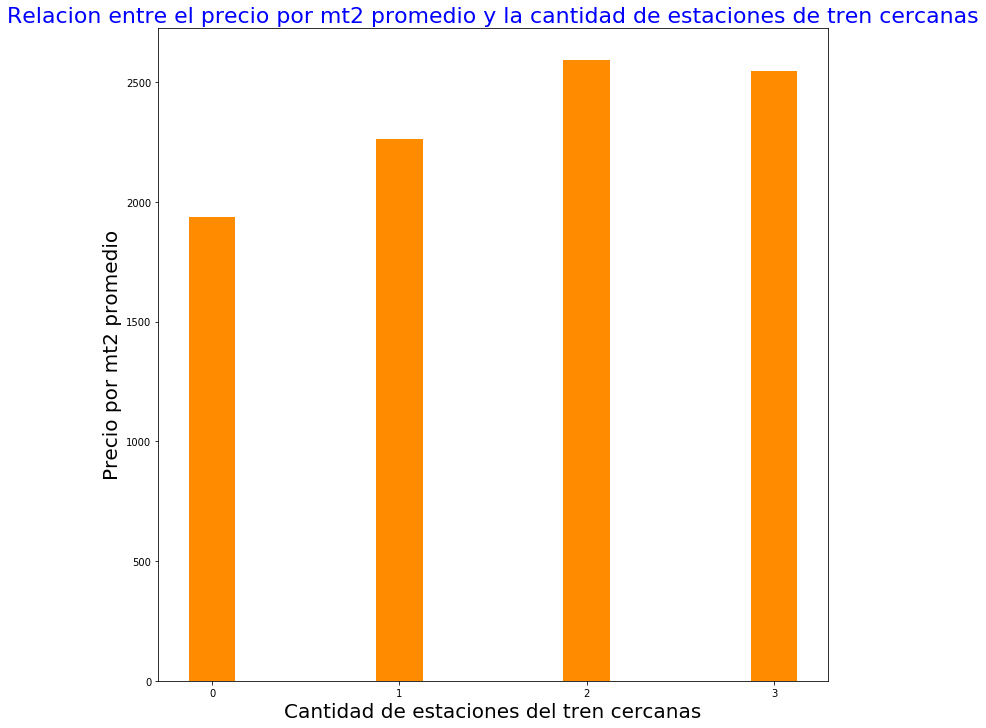

In [49]:
#Las propiedades que tienen al menos una estacion de Tren a 700m tienen en promedio mayor precio por m2
groupbyTren = propiedadesCercanasTren.groupby('cant_trenes_cercanos')
mediaGroupbyTren = groupbyTren['price_usd_per_m2'].agg(['mean'])

cant_estaciones = np.arange(groupbyTren.ngroups)

plt.figure(figsize=(12, 12));
plt.bar(cant_estaciones, mediaGroupbyTren['mean'], width= 0.25, color = 'darkorange')
plt.xticks(cant_estaciones, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la cantidad de estaciones de tren cercanas', fontsize = 22, color = 'Blue')
plt.xlabel('Cantidad de estaciones del tren cercanas', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)

#Al igual que pasa con el subte, el precio por m2 promedio aumenta si la propiedad esta cercana 
#a una estacion de tren, pero dicho aumento no es tan drastico como sucedia con el subte.
#Se necesitan al menos dos estaciones de tren cerca, para que el promedio del precio por m2 de una propiedad 
#sea considerable con respecto a aquellas propiedades que no poseen un estacion de tren cercana.


In [50]:
def obtener_distancia_subteytren(geoPos):
    return obtener_subtes_cercanos(geoPos) + obtener_distancias_a_trenes(geoPos)

In [51]:
propiedadesCercanasSubteyTren = propiedadesDistancia.copy(deep = True)
propiedadesCercanasSubteyTren['cant_subteytren'] = propiedadesCercanasSubteyTren['geoPos'].apply(obtener_distancia_subteytren)  

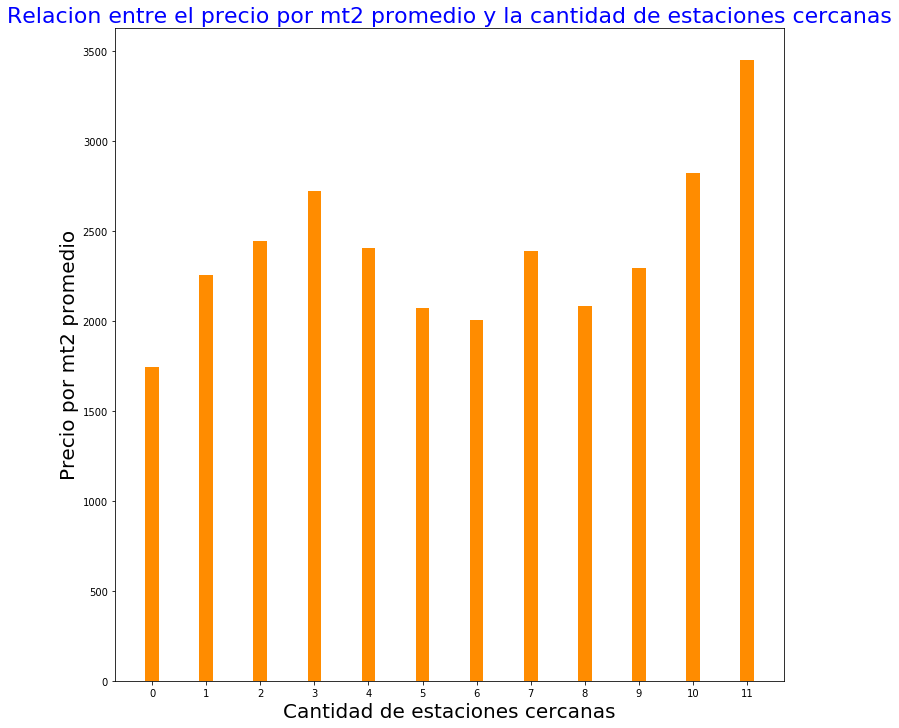

In [52]:
groupbySubteTren = propiedadesCercanasSubteyTren.groupby('cant_subteytren')
mediarGoupbySubteTren = groupbySubteTren['price_usd_per_m2'].agg(['mean'])

cant_estaciones = np.arange(groupbySubteTren.ngroups)

plt.figure(figsize=(12, 12));
plt.bar(cant_estaciones, mediarGoupbySubteTren['mean'], width= 0.25, color = 'darkorange')
plt.xticks(cant_estaciones, size = 'medium')
plt.title('Relacion entre el precio por mt2 promedio y la cantidad de estaciones cercanas', fontsize = 22, color = 'Blue')
plt.xlabel('Cantidad de estaciones cercanas', fontsize = 20)
plt.ylabel('Precio por mt2 promedio', fontsize = 20)


In [53]:
def distanciaANuevasEstaciones(geoPos):
   
    #Ubicacion de las estaciones
    Cordoba = (-34.598691, -58.403841) #Inicio Obras: 17 ene 2012 - Inauguracion: 18 dic 2015
    SantaFe = (-34.594848, -58.402517) #Inicio Obras: 17 ene 2012 - Inauguracion: 12 jul 2016
    LasHeras = (-34.587879, -58.397970) #Inicio Obras: 17 ene 2012 - Inauguracion: 18 dic 2015

    distACordoba = distancia(geoPos, Cordoba)
    distASantaFe = distancia(geoPos, SantaFe)
    distALasHeras = distancia(geoPos, LasHeras)
    

    return min(distACordoba, distASantaFe, distALasHeras)

## Veamos el precio del m2 en recoleta por año

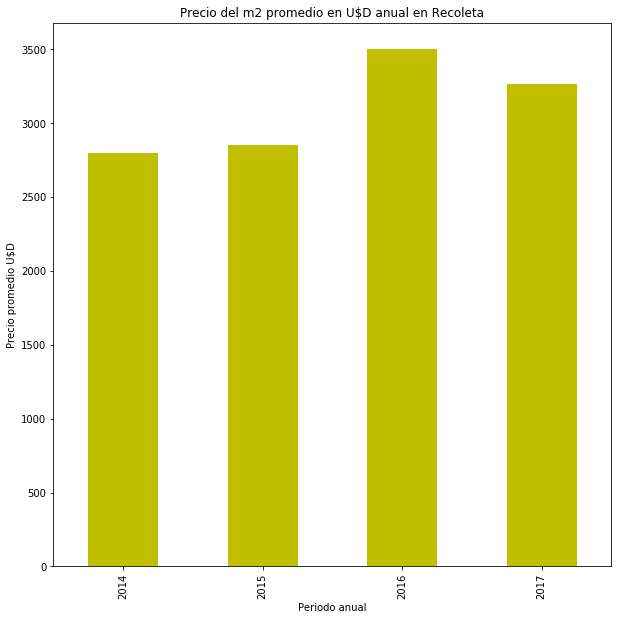

In [54]:
propiedadesEnRecoleta = propiedadesPorBarrio.copy(deep = True)
propiedadesEnRecoleta = propiedadesEnRecoleta.loc[propiedadesEnRecoleta.place_name.str.contains('Recoleta') ,:]
recoletaPorMes = propiedadesEnRecoleta.groupby(propiedadesEnRecoleta.created_on.dt.year).agg([np.size, np.mean])
recoletaPorMes = recoletaPorMes.loc[recoletaPorMes['price_usd_per_m2']['size'] > 5.0, :]

plt.figure(figsize=(10,10))
recoletaPorMes['price_usd_per_m2']['mean'].plot(kind ='bar', color='y', legend=False)
plt.title('Precio del m2 promedio en U$D anual en Recoleta')
plt.xlabel("Periodo anual")
plt.ylabel("Precio promedio U$D")

## Se puede ver una suba de precios de 2015 a 2016. Esto puede ser por la cercania de las propiedades a las nuevas estaciones del subte H. Veamoslo
#### Precio por m2 en relacion a la cercania al Subte H y al año de su inauguracion
##### Tomando propiedades con distancia 400mts

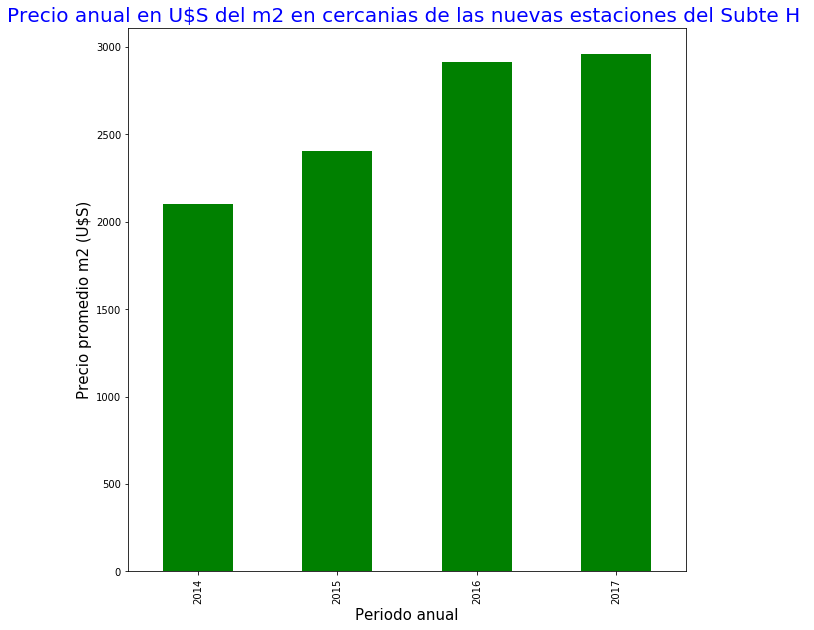

In [57]:
cercanasANuevasEstaciones = propiedadesDistancia.copy(deep = True)
cercanasANuevasEstaciones.loc[:, 'distanciaAEstacion'] = cercanasANuevasEstaciones['geoPos'].apply(distanciaANuevasEstaciones)
#Solo dejo las propiedades que estan a menos de 400mts
cercanasANuevasEstaciones = cercanasANuevasEstaciones.loc[cercanasANuevasEstaciones["distanciaAEstacion"] < 400, :]

cercanasANuevasEstaciones.groupby(cercanasANuevasEstaciones.created_on.dt.year)['price_usd_per_m2'].agg(np.mean)\
.plot(kind ='bar', color='g', legend = False, figsize = (10, 10))
plt.title("Precio anual en U$S del m2 en cercanias de las nuevas estaciones del Subte H ", fontsize = 20, color = 'blue')
plt.xlabel("Periodo anual", fontsize = 15)
plt.ylabel("Precio promedio m2 (U$S)", fontsize = 15)

## Viendo que pasa en Villa Urquiza en los ultimos 2 años

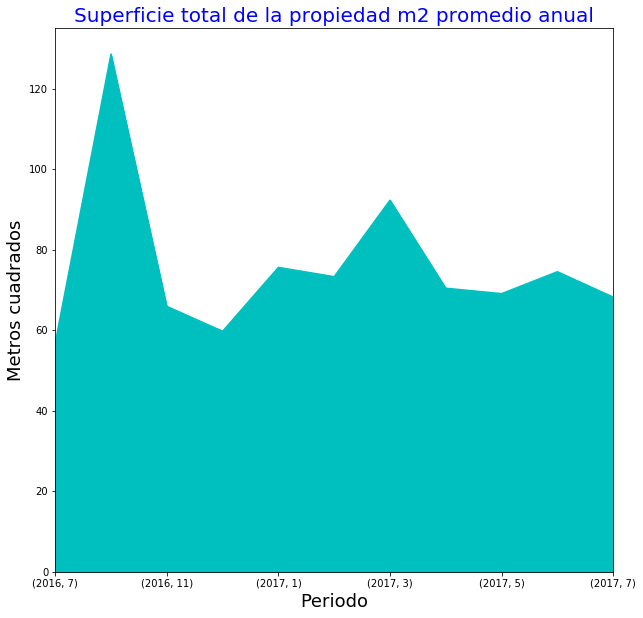

In [58]:
propVillaUrquiza = propiedadesDistancia.copy(deep=True)
propVillaUrquiza20172016 = propVillaUrquiza.loc[(propVillaUrquiza.place_name.str.contains('Villa Urquiza')) & (propVillaUrquiza.created_on.dt.year > 2015), :]


propVillaUrquiza20172016grouped = propVillaUrquiza20172016.groupby([propVillaUrquiza20172016.created_on.dt.year, propVillaUrquiza20172016.created_on.dt.month ])\
['surface_total_in_m2'].agg(['mean', 'size'])
#Solo tomo los que tengan mas de 10 casas
propVillaUrquiza20172016grouped = propVillaUrquiza20172016grouped.loc[propVillaUrquiza20172016grouped['size'] > 10, :]

#Superficie total de las publicaciones (fue bajando a lo largo de los ultimos meses)
propVillaUrquiza20172016grouped['mean'].plot( kind = 'area', color = 'c', figsize = (10,10))
plt.title("Superficie total de la propiedad m2 promedio anual", fontsize = 20, color = 'blue')
plt.xlabel("Periodo", fontsize = 18);
plt.ylabel("Metros cuadrados", fontsize =18);
#Porcentaje cubierto promedio

## Vemos que el promedio de la superficie cubierta para las propiedades publicadas fue bajando y esta causa puede ser la expansion del barrio, el cual crecio "para arriba", construyendose muchos edificios. Esto lo podemos comprobar facilmente:

In [59]:
propVillaUrquiza20172016['property_type'].value_counts()

apartment    834
PH            69
house         43
store         17
Name: property_type, dtype: int64

Aca se ve como se vendieron muchos mas departamentos que otro tipo de propiedad durante estos ultimos dos años.